In [1]:
import numpy as np
import tensorly as tl
from tensorly.decomposition import non_negative_parafac_hals
from tlgcp import generalized_parafac, stochastic_generalized_parafac
import matplotlib.pyplot as plt
from tensorly.metrics import RMSE
from tlgcp.utils import loss_operator
import time

def each_iteration(a, b):
    fig=plt.figure()
    fig.set_size_inches(10, fig.get_figheight(), forward=True)
    plt.plot(a)
    plt.plot(b)
    plt.yscale('log')
    plt.legend(['GCP','S-GCP'], loc='upper right') 

np.set_printoptions(precision=2)

# Example use of Generalized CP for integer-valued tensor
# -------------------------------------------------------
In this example, a tensor containing integer values is decomposed in the CP format using Generalized CP [Hong, Kolda, Duersch 2019].
To use GCP decomposition efficiently, the correct loss should be selected according to the input tensor.
Here, we use Bernoulli odds loss, which stems from the maximum likelihood estimator when the data is generated as a Bernouilli process (integer values) with low-rank CP parameters. Let us note that we suggest to use random init rather than Singular Value Decomposition with using GCP decomposition.

In [2]:
# Parameters
init = 'random'
rank = 5
loss = 'bernoulli_odds'
shape = [60, 80, 50]

To create a synthetic tensor wih Bernoulli distribution, we use random cp and numpy
binomial functions:

In [3]:
cp_tensor = tl.cp_to_tensor(tl.random.random_cp(shape, rank))
array = np.random.binomial(1, cp_tensor / (cp_tensor + 1), size=shape)
tensor = tl.tensor(array, dtype='float')

Running GCP is quite simple, and boils down to calling the `generalized_parafac` routine as follows.

In [4]:
tic = time.time()
tensor_gcp, errors_gcp = generalized_parafac(tensor, rank=rank, init=init, return_errors=True, loss=loss,
                                             n_iter_max=100)
cp_reconstruction_gcp = tl.cp_to_tensor((tensor_gcp))
time_gcp = time.time() - tic

Stochastic GCP (SGCP) decomposition function requires batch size, epochs and beta
parameters (for ADAM) as input in addition to GCP decomposition inputs. Fortunately,
Learning Rate (LR) and beta parameters can be fixed following the literature on
ADAM optimization. Besides, in case of badly chosen LR, SGCP updates the LR by dividing
LR by 10 after each failed iteration until reaching 20 successive bad iteration.

In [5]:
tic = time.time()
tensor_sgcp, errors_sgcp = stochastic_generalized_parafac(tensor, rank=rank, init=init,
                                                          return_errors=True, loss=loss, lr=1e-3,
                                                          n_iter_max=1000, batch_size=50, epochs=100)
cp_reconstruction_sgcp = tl.cp_to_tensor((tensor_sgcp))
time_sgcp = time.time() - tic

Sufficient number of bad epochs


To compare GCP decompositions, we choose non-negative CP with HALS (NN-CP)
since Bernoulli odds imply a nonnegativity constraint on the CP tensor.

In [6]:
tic = time.time()
tensor_cp, errors = non_negative_parafac_hals(tensor, rank=rank, n_iter_max=100, init=init, return_errors=True)
cp_reconstruction = tl.cp_to_tensor((tensor_cp))
time_cp = time.time() - tic

In this example, we use binary tensor `tensor` as an input. It is possible to
have binary reconstructed tensor by using numpy binomial function on the estimated cp tensors. 
Below instead we compare the esimated cp tensors with the true `cp_tensor`, which is the true goal of GCP.

In [7]:
print("RMSE for GCP:", RMSE(cp_tensor, cp_reconstruction_gcp))
print("RMSE for SGCP:", RMSE(cp_tensor, cp_reconstruction_sgcp))
print("RMSE for NN-CP:", RMSE(cp_tensor, cp_reconstruction))

print("Loss for GCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_gcp, loss)))
print("Loss for SGCP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction_sgcp, loss)))
print("Loss for NN-CP:", tl.sum(loss_operator(cp_tensor, cp_reconstruction, loss)))

print("GCP time:", time_gcp)
print("SGCP time:", time_sgcp)
print("NN-CP time:", time_cp)

RMSE for GCP: 0.08837666153582645
RMSE for SGCP: 0.14031012836592588
RMSE for NN-CP: 0.3202798895204549
Loss for GCP: 0.6782394441956142
Loss for SGCP: 0.6965591776791499
Loss for NN-CP: 0.8538427872832611
GCP time: 1.5459728240966797
SGCP time: 8.270816564559937
NN-CP time: 0.882404088973999


We compare the results according to processing time, root mean square error and
the selected loss. According to the final Bernoulli loss,
both GCP and SGCP give better results than NN-CP. Since SGCP requires many
iteration inside each epoch, processing time is much more than the others. We can also compare the methods by error per iteration plot:

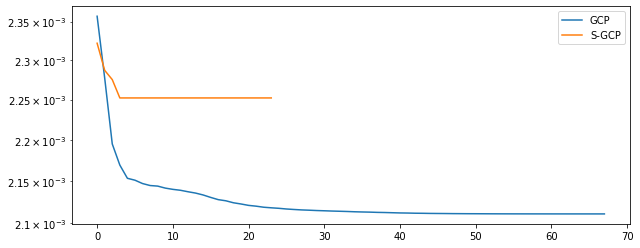

In [8]:
each_iteration(errors_gcp, errors_sgcp)